    #BA476 Machine Learning Practical Assignment 2 -  K-Means Clustering for Market Segmentation

The purpose of this assignment is to use K-Means Clustering to better understand customer behavior. In this assignment, we are taking a look at transaction data for a large e-Commerce company and trying to convert that transaction information into customer-level data for actionable insights. The goal of this assignment is to perform market segmentation based on purchase behaviour. 

We will use Pandas to manipulate dataframes, Scikit-learn to create the clusters, and Matplotlib for visualization. The deliverable for this assignment is  a PDF file that you will produce by converting your notebook to html and then printing the html page (as in PA1). As a reminder your notebook should contain all the code you used to generate your results – be sure to try writing concise code and comment out what you're doing to explain the code. Submit your PDF file on gradescope when you're done. 



## Importing and cleaning data

Get started by importing the necessary packages and  importing the dataset. 

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans

#Create the initial dataframe from the UCI repository
df = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")

#Online Retail.xlsx
#http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

Inspect the dataframe to understand the columns and rows. We have around half a million rows, end each row corresponds to  an item purchased by some customer. Notably, a row is *not* a transaction, you'll notice several rows share the same invoice number. 

In [109]:
print(df.shape)
df.head(10)


(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


Check the dataframe for null entries in each column.

In [140]:
#Check for null values in the dataframe by column
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

###Cleaning the Data (3 Points)

Remove cancelled orders (quantity<=0), orders with no description (description = ""), and records without a customerID.  

In [141]:
# (2 points)

#making copy of df
df_copy = df


# Drop cancelled orders 
index_num = df[df["Quantity"] <= 0].index
df = df.drop(index_num)


# Drop blank descriptions since we do not know what the customer ordered 
df = df.dropna(subset = ['Description']) 
index_blank = df[df["Description"] == ''].index
df = df.drop(index_blank)

# Drop records without CustomerID 
df = df.dropna(subset = ['CustomerID'])
index_blank = df[df["CustomerID"] == ''].index
df = df.drop(index_blank)


df.head()
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Sales          0
dtype: int64

Add a column with the total revenue (sales price) per row (quantity sold times price per unit). 

In [142]:
# Calculate total sales from the Quantity and UnitPrice

df["Sales"] = df["Quantity"] * df["UnitPrice"]

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


###Create a dataframe at the invoice level  (3 Points)
Ultimately we want to say something about customers but first, let's investigate at the order/invoice level. Aggregate the data so that you have a new dataframe with one row per invoice. Keep track of the value of each transaction, the number of unique items sold, the total number of items sold and the customer who bought it. Remember to set your column names appropriately. 

In [143]:
order_df_colnames = ['InvoiceNo', 'Sales', 'UniqueItems', 'TotalItems', 'CustomerID']
# Create order_df grouping by InvoiceNo 
# Use an agg function to create Sales, StockCode, Quantity, and CustomerID as are described above

order_df = df.groupby('InvoiceNo', as_index=False).agg({
    'Sales':sum,
    'StockCode':pd.Series.nunique,
    'Quantity':sum,
    'CustomerID':min
})



order_df.columns = order_df_colnames
order_df.head()

,InvoiceNo,Sales,UniqueItems,TotalItems,CustomerID
0,536365,139.12,7,40,17850.0
1,536366,22.20,2,12,17850.0
2,536367,278.73,12,83,13047.0
3,536368,70.05,4,15,13047.0
4,536369,17.85,1,3,13047.0


###Visualize the order data and remove excessively large purchases (3 points)
Create a scatter plot of your new dataframe, with total items on the X axis and Sales on the Y axis. You will use this to visualize outliers before removing them. Once you see the plot, you should be able to filter the dataframe on each axis to remove the clear outliers. We chose the Sales and TotalItems axes because we wanted to omit orders where the total sales was extreme or orders with an extreme number of items. The only other column to consider here would be uniqueitems and we do not consider it because the totalitems column already does the same job and intuitively, we want to know total sales and total items. 

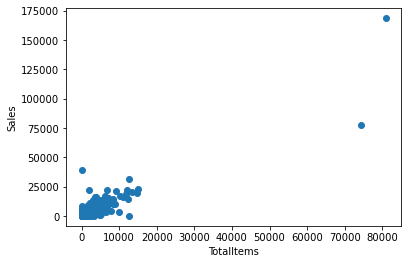

In [144]:
#Create a scatter plot
x = order_df["TotalItems"]
y = order_df["Sales"]
plt.scatter(x, y)
plt.xlabel('TotalItems')
plt.ylabel('Sales')
plt.show()


Remove outliers on both axes from the dataframe, then add labels and reprint the chart with a clearer look at the data's behavior.

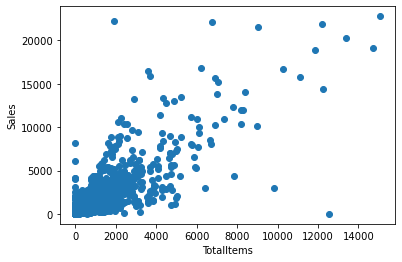

18532


In [145]:
#Given the plot above remove outliers on both the totalitems and sales axis

#Remove totalitems outliers in order_df using the scatter plot
order_df = order_df.loc[order_df['TotalItems'] <= 60000]

#Remove sales outliers in order_df using the scatter plot
order_df = order_df.loc[order_df['Sales'] <= 30000]

# after filtering, my order_df has 18532 rows

x = order_df["TotalItems"]
y = order_df["Sales"]
plt.scatter(x, y)
plt.xlabel('TotalItems')
plt.ylabel('Sales')
plt.show()

print(len(order_df.index))

###Create a customer dataframe and remove outliers using IQR (11 Points)
Create a new dataframe at the customer level using the order dataframe. You can use the invoice dataframe for reference as the process is similar. Columns included should be (1) the total dollar amount of 'sales' across orders, (2) the number of different orders by the customer, (3) the average number of unique items in an order, and (4) the total items ordered across all orders.

In [146]:
cust_df_colnames = ['TotalSales', 'OrderCount', 'AvgUniqueItems', 'TotalItems']

#Create the customer dataframe
customer_df = order_df.groupby(['CustomerID']).agg({
    'Sales':sum,
    'InvoiceNo': pd.Series.count,
    'UniqueItems':sum,
    'TotalItems':sum
})

customer_df['UniqueItems'] = customer_df['UniqueItems'] / customer_df['InvoiceNo']


#Add titles to the columns you included
customer_df.columns = cust_df_colnames
customer_df.tail()



,TotalSales,OrderCount,AvgUniqueItems,TotalItems
CustomerID,,,,
18280.0,180.60,1,10.000000,45
18281.0,80.82,1,7.000000,54
18282.0,178.05,2,6.000000,103
18283.0,2094.88,16,43.062500,1397
18287.0,1837.28,3,22.666667,1586


Now add a new column showing each customer's average order value. 

In [147]:
#Create a new column, AvgOrderValue (total sales divided by # orders per customer

customer_df['AvgOrderValue'] = customer_df['TotalSales'] / customer_df['OrderCount']

customer_df

len(customer_df)

4338

Now, create a scatter plot with total sales on the x axis and order count on the y axis to check for outliers

(4338, 5)


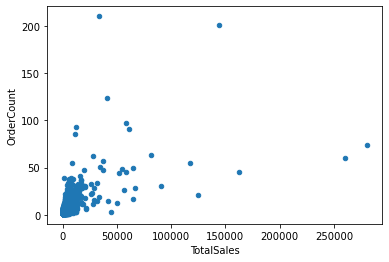

In [148]:
#Create a scatter plot of total sales and order count to visualize our current data  
customer_df.plot.scatter(x='TotalSales', y ='OrderCount')
print(customer_df.shape)
plt.show()

This time, let's calculate the interquartile range (IQR), the difference between the upper and lower quartiles, and use this to compute lower (upper)bounds on the `Sales` column equal to the $Q_1 - 1.5\times IQR\,\,$ (and $Q_3 + 1.5\times IQR$, respectively).

In [149]:
#Instead of using a visual heuristic and boxplot, let's try implementing IQR to detect our outliers.
sales_quartile_75, sales_quartile_25 = np.quantile(customer_df['TotalSales'], .75), np.quantile(customer_df['TotalSales'], .25)

sales_iqr =  sales_quartile_75 - sales_quartile_25

sales_top_bound, sales_bottom_bound =  (sales_quartile_75 + 1.5*sales_iqr), (sales_quartile_25 - (1.5 * sales_iqr))

print(sales_bottom_bound, sales_top_bound)


#-1723.9362500000002 -1723.9362500000002

-1723.9362500000002 3691.99375
1353.9825
1661.02 307.03749999999997


Now, repeat the process to compute similar bounds on the number of orders per customer. 

In [150]:
#Instead of using a visual heuristic and boxplot, let's try implementing IQR to detect our outliers.

order_quartile_75, order_quartile_25 = np.percentile(customer_df["OrderCount"], [75 ,25])

order_iqr =  order_quartile_75 - order_quartile_25

order_top_bound, order_bottom_bound =  order_quartile_75 + (1.5 * order_iqr), order_quartile_25 - (1.5 * order_iqr)

print(order_bottom_bound, order_top_bound)
print(order_quartile_75, order_quartile_25)

-5.0 11.0
5.0 1.0


Now, filter the dateframe to exclude rows where the orders or sales value exceed the bounds you computed. 

In [151]:
customer_df = customer_df[customer_df["OrderCount"].between(order_bottom_bound, order_top_bound, inclusive = "neither")]
customer_df = customer_df[customer_df["TotalSales"].between(sales_bottom_bound, sales_top_bound, inclusive = "neither")]

customer_df.head()

,TotalSales,OrderCount,AvgUniqueItems,TotalItems,AvgOrderValue
CustomerID,,,,,
12348.0,1797.24,4,6.750,2341,449.310
12349.0,1757.55,1,73.000,631,1757.550
12350.0,334.40,1,17.000,197,334.400
12352.0,2506.04,8,10.375,536,313.255
12353.0,89.00,1,4.000,20,89.000


Visualize your data. Notice what outliers were removed.

(3841, 5)


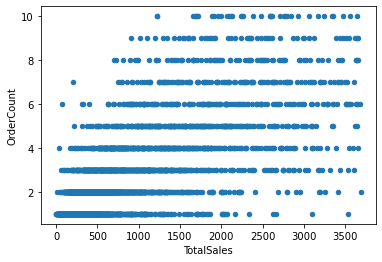

In [152]:
#plotting your data
customer_df.plot.scatter(x='TotalSales', y='OrderCount')
print(customer_df.shape)

Finally, create a normalized dataframe, by standardizing each column of cust_df (subtract the mean, scale by the standard deviation). You should be able to do this in one line of code. 

In [153]:
#Create normalized_df, a normalized version of cust_df
normalized_df = (customer_df - customer_df.mean())/customer_df.std()


You'll notice that we were pretty aggressive in removing outliers, we went from 4338 customers to 3841. It'll help us get cleaner clusters later for the purpose of this exercise, but in practice we should be more careful. 

##  K-Means Clustering Algorithm  (5 points)

We don't know how many clusters is appropriate, so we will do $k$-means clustering for $k \in [2, 3, \ldots, 15]$ and use the [silhouette-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) to choose the best value of $k$. Be sure to read the documentation to understand silhouettes, briefly, higher scores are better. Training may take a few seconds. 

0.5436366186277757 0.3540044131204636


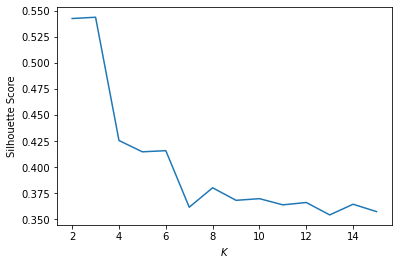

In [154]:
from sklearn.metrics import silhouette_score

krange = list(range(2,16))
cols = ['TotalSales', 'OrderCount',  'TotalItems', 'AvgOrderValue']
X = normalized_df[cols].values

silhouette = []


# Iterate over the range of K values, which denotes the number of clusters
for n in krange:
    kmeans = KMeans(n_clusters=n).fit(X)
    labels = kmeans.labels_
    silhouette.append(silhouette_score(X, labels))
    

print(max(silhouette), min(silhouette))

plt.plot(krange, silhouette)
plt.xlabel("$K$")
plt.ylabel("Silhouette Score")
plt.show()

##Investigate the clusters (4 points)
Using the plot above, identify the best choice of $k$. Run $k$-means clustering with the chosen $k$, then create a new dataframe with an additional column showing the cluster of every customer. You should investigate your clusters to make sure a cluster doesn't just consist of one or two outliers. 

In [164]:
#Set the K value and run the kmeans algorithm on the normalized dataframe
k =  3
kmeans =  KMeans(n_clusters=k).fit(X)

#copy the columns from normalized_df 
cluster_df = normalized_df[cols].copy(deep=True)

#Add the labels from the k-means algoithm to the cluster column in cluster_df
cluster_df['Cluster'] = kmeans.labels_

#Run groupby to see how many instances are in each cluster
cluster_df.groupby('Cluster').count()


,TotalSales,OrderCount,TotalItems,AvgOrderValue
Cluster,,,,
0,2755,2755,2755,2755
1,842,842,842,842
2,244,244,244,244


Create a new dataframe with the centroid of each cluster. You can easily access the centroids in your estimators `cluster_centers_` attribute. 

In [165]:
# Store the centroids in a dataframe
centers = kmeans.cluster_centers_

#Create a df using the centroids stored in the previous step
cluster_center_df = pd.DataFrame(centers)

#Rename the columns of your df to the correct names
cust_df_colnames = ['TotalSales', 'OrderCount', 'TotalItems', 'AvgOrderValue']
cluster_center_df.columns = cust_df_colnames

cluster_center_df

,TotalSales,OrderCount,TotalItems,AvgOrderValue
0,-0.509306,-0.409717,-0.422617,-0.284992
1,1.391095,1.491340,1.194369,0.130675
2,0.950144,-0.520240,0.650215,2.766906


### Visualize and interpret clusters (8 points)
Create scatter plots to visualize the relationship between your features and clusters. The template iterates over the respective x, y axes of each plot. You should create one pane with four plots using `cluster_df`. 

The plots in the second pane were created by first ranking the data in `cluster_df`. You can try to do this if it helps you interpret the clusters, but will not be penalised if you don't. 

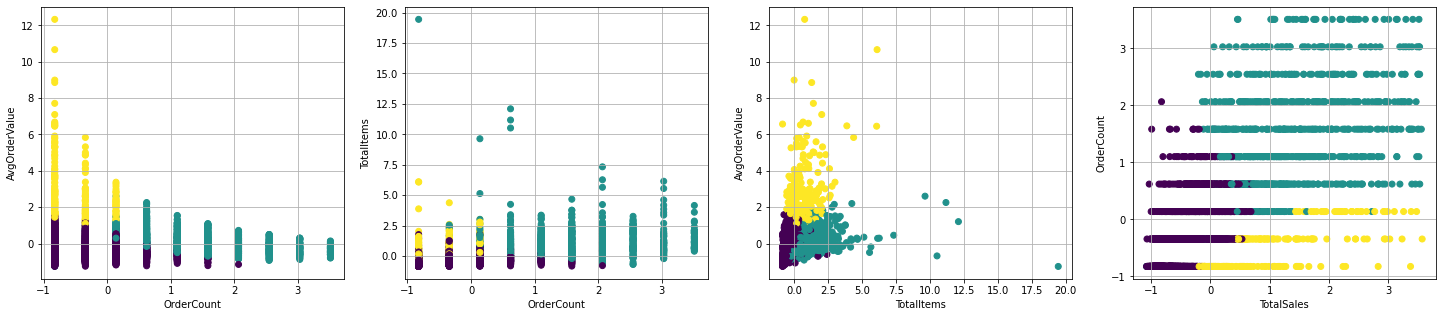

In [190]:
plots = [('OrderCount', 'AvgOrderValue'),   ('OrderCount', 'TotalItems'), ('TotalItems', 'AvgOrderValue') , ('TotalSales', 'OrderCount') ] 
colors = [ 'blue', 'orange', 'green', 'purple']


plot_df = cluster_df
fig, axs = plt.subplots(1, len(plots) , figsize=(25, 5))


for idx, col_pair in zip(range(len(plots)), plots): 

  #Iterate through all the clusters
    for cluster in range(k):
        
        color_in = colors[cluster]

    #Create a scatter plot based on the X and Y axis in each plot, p using the colors variable
    labels = plot_df["Cluster"]
    
    axs[idx].scatter(plot_df[col_pair[0]], plot_df[col_pair[1]], c = labels)
        
    #Set axis labels
    axs[idx].set_xlabel(col_pair[0])
    axs[idx].set_ylabel(col_pair[1])
    
    axs[idx].grid()



Thouroughly characterize the types of customers and their purchase behaviour for each cluster. (5 points)

Yellow = cluster 2
purple = cluster 0
blue = cluster 1

Cluster 2 appears to be an active customer at the company. The groups has overall high total sales, though their order count seems to be significantly less than the other clusters. Additionally, they have what looks like the highest average order value. To characterize this group I would liken them to a customer that buys in bulk at high quantities.

Cluster 0 customers seem spend the least out of the three for the amount of orders that the place. I think you could classify them as a normal shopper who purchases when necessary. In terms of purchasing behavior, maybe they shop when they have discounts or deals.

Cluster 1 looks a little more all over the board then the other clusters. It seems that there are people within cluster 1 that have placed a varying range of order numbers. However, their total sales seem to be pretty consistently high. They also have varying average order values. With their purchasing behavior they are more in the middle I would say.


###Dive Deeper into the High Value Cluster and display the Top Products (4 points)
Investigate the cluster with the highest order value (on average) further by printing the top 10 best-selling products in the cluster. You will need to use your original dataframe coupled with the cluster number of each customer. 

In [128]:
high_value_cluster_number =  cluster_df.groupby('Cluster').mean()

# filter to get the customers in the high value cluster
high_value_cluster_number = high_value_cluster_number["AvgOrderValue"].idxmax()


# identify the most commonly purchased items
c = cluster_df.loc[cluster_df["Cluster"] == high_value_cluster_number]
c = pd.DataFrame(c.index)


original_s = df.loc[df["CustomerID"].isin(c["CustomerID"])]

products = original_s['StockCode'].value_counts()[:10].index.tolist()
productslist = original_s['StockCode'].value_counts().nlargest(10)

#prints products alone
print(products)

#prints frequency
print(productslist)


[22423, 22960, 22720, '85099B', 21212, 'POST', 22961, 22086, 23203, 84879]
22423     89
22960     61
22720     58
85099B    55
21212     53
POST      51
22961     48
22086     46
23203     45
84879     44
Name: StockCode, dtype: int64


## Inform Strategy (6 points)
Now that you have a better understanding of customers' purchase behaviour, how would you change your practices?

Write 1-2 sentences with a business recommendation (this can cover marketing, operations,  etc. as long as it refers back to the results of your cluster analysis) for each of the clusters. 

The cluster's give us a lot of insight into different customer segments. From a business standpoint, you may want to target your marketing towards individuals within cluster 2 (those with the highest average order value) or individuals like them. Operationally, you can focus on keeping the popular products within cluster 2 stocked since you know they high demand for high-paying customers.

## Preparing for submission

To convert your notebook to html, change the string below to reflect the location of the notebook in your Google Drive. 

In [129]:
path_to_file = '/content/drive/My Drive/somepath/PA2-market-segmentation.ipynb'

Now execute the code cell below. After execution there should be an html file in the same Google Drive folder  where this notebook is located. Download the html file, open with your browser and print to pdf, then submit the pdf on the course page along with your notebook. 

**NOTE:** this seems to fail if your path contains spaces - move it to a location without spaces and try again. 

In [130]:
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

import re, pathlib, shutil

from google.colab import drive
drive.mount('/content/drive')

'apt' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'google'

In [ ]:
nbpath =  pathlib.PosixPath(path_to_file)
!jupyter nbconvert "{nbpath.as_posix()}" --to html --output "{nbpath.stem.replace(" ", "_")}"

*Acknowledgements:* This example makes use of the [UCI MLR dataset on online retail](http://archive.ics.uci.edu/ml/datasets/online+retail). 
Much of this exercise is based on an exercise in  "Hands-On Data Science for Marketing" by Packt  and a treatment of that by Mike Nemke.